<a href="https://colab.research.google.com/github/otausendschoen/Image_Classification_Diffusion-Augmentation/blob/main/03_10%25Synthetic_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifier Tests

In [1]:
## Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -U datasets huggingface_hub fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.4/509.4 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 59.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.31.2
    Uninstalling huggingface-hub-0.31.2:
      Successfully uninstalled huggingface-hub-0.31.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency c

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset, Subset
from torchvision import transforms, models
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import random
from collections import Counter, defaultdict
from torchvision.datasets import ImageFolder
import pandas as pd
import seaborn as sns
import zipfile

In [4]:
# Set random seeds for reproducibility
random.seed(8)
np.random.seed(8)
torch.manual_seed(8)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(8)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Loading the dataset

EuroSAT available on hugging face dataset to save loading time.

In [5]:
# Load the EuroSAT dataset directly from Hugging Face
print("Loading dataset...")
dataset = load_dataset("jonathan-roberts1/EuroSAT")
print(dataset)

Loading dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

(…)-00000-of-00001-26e80b6de2d4dca7.parquet:   0%|          | 0.00/88.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/27000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 27000
    })
})


In [ ]:
# Choose proportion of the dataset to use (1=100%, 2=50%, 10=10% of dataset)
proportion = 10
dataset["train"] = dataset["train"].shuffle(seed=42).select(
    range(len(dataset["train"]) // proportion) 
)

# Confirmation of dataset size
len(dataset["train"])

In [8]:
# Create train-validation split
train_val_dataset = dataset["train"]
train_indices, val_indices = train_test_split(
    range(len(train_val_dataset)),
    test_size=0.2,
    stratify=[item['label'] for item in train_val_dataset],
    random_state=8
)

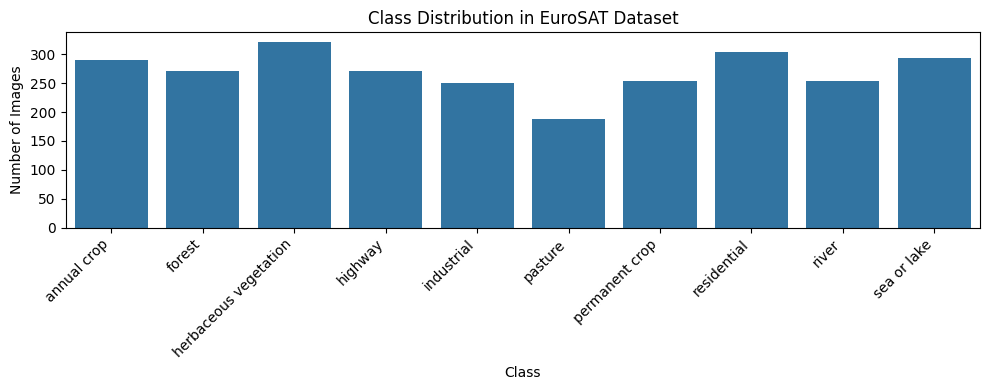

,Class,Percentage,Number of Images
0,annual crop,10.78%,291
1,forest,10.04%,271
2,herbaceous vegetation,11.93%,322
3,highway,10.04%,271
4,industrial,9.30%,251
5,pasture,6.96%,188
6,permanent crop,9.41%,254
7,residential,11.26%,304
8,river,9.41%,254
9,sea or lake,10.89%,294


In [9]:
# Checking Ratios

from collections import Counter
import pandas as pd

# Count labels
labels = dataset["train"]["label"]
label_names = dataset["train"].features["label"].names
label_counts = Counter(labels)

# Build DataFrame for display
total = sum(label_counts.values())
df = pd.DataFrame([
    {"Class": label_names[i],
     "Percentage": f"{(count / total) * 100:.2f}%",
     "Number of Images": count}
    for i, count in sorted(label_counts.items())
])

# Display as a table
import seaborn as sns
plt.figure(figsize=(10, 4))
sns.barplot(data=df, x="Class", y="Number of Images")
plt.xticks(rotation=45, ha='right')
plt.title("Class Distribution in EuroSAT Dataset")
plt.tight_layout()
plt.show()

# Show DataFrame
import IPython.display as disp
disp.display(df)

Images were preprocessed using a standard pipeline for transfer learning with ImageNet-pretrained models. First, the EuroSAT images were resized from their native 64×64 resolution to 224×224 pixels to match the input requirements of the ResNet18 architecture. The pixel values were then converted to tensors and normalized using ImageNet's channel-wise mean (0.485, 0.456, 0.406) and standard deviation (0.229, 0.224, 0.225) to ensure compatibility with the pretrained weights. This preprocessing approach is critical when leveraging transfer learning, as it aligns the input distribution with what the pretrained network expects, allowing effective feature extraction from the early convolutional layers despite the domain shift between natural images and satellite imagery.

In [10]:
# Function to visualize class distribution
def plot_class_distribution(labels, title, label_names=None):
    if label_names is None:
        label_names = dataset["train"].features["label"].names

    # Count and build DataFrame
    label_counts = Counter(labels)
    total = sum(label_counts.values())
    df = pd.DataFrame([
        {
            "Class": label_names[i] if isinstance(i, int) else i,
            "Percentage": f"{(count / total) * 100:.2f}%",
            "Number of Images": count
        }
        for i, count in sorted(label_counts.items())
    ])

    # Plot bar chart
    plt.figure(figsize=(10, 4))
    sns.barplot(data=df, x="Class", y="Number of Images")
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    plt.tight_layout()
    plt.show()

    # Display the table
    return df

We define the ResNet-18 model

In [11]:
# Define the ResNet-18 model
class ResNet18Classifier(nn.Module):
    def __init__(self, num_classes=10, pretrained=True):
        super(ResNet18Classifier, self).__init__()

        # For newer PyTorch versions (1.13+)
        try:
            self.model = models.resnet18(weights='IMAGENET1K_V1' if pretrained else None)
        except:
            # Fallback for older versions
            self.model = models.resnet18(pretrained=pretrained)

        # Replacing the final fully connected layer
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

In our implementation, we created a custom EuroSATDataset class that inherits from PyTorch's Dataset, providing an efficient interface between our raw satellite imagery and the training pipeline. This class handles the application of image transformations and maintains the train-validation split through indexing, allowing flexible access to different subsets of the data. We then instantiated separate training and validation datasets with their respective transformations, and wrapped them in DataLoaders with a batch size of 32. The training loader incorporates shuffling to improve model generalization, while the validation loader maintains deterministic ordering. This approach enables efficient batched processing and parallelized data loading, which is essential for training deep convolutional networks like ResNet18 on large image datasets.

In [12]:
# Create PyTorch datasets
class EuroSATDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices=None, transform=None):
        self.dataset = dataset
        self.indices = indices if indices is not None else range(len(dataset))
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        sample = self.dataset[self.indices[idx]]
        image = sample['image']
        label = sample['label']

        if self.transform:
            image = self.transform(image)

        return image, label

In [13]:
# Training function
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for images, labels in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

    return epoch_loss, epoch_acc, epoch_f1

In [14]:
# Validation function
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

    return epoch_loss, epoch_acc, epoch_f1

Our implementation establishes a comprehensive training framework with integrated early stopping to prevent overfitting on the EuroSAT dataset. The training loop executes up to 30 epochs, with patience set to 7 epochs for early termination if validation accuracy fails to improve. Within each epoch, we conduct a full training pass using our train_one_epoch function, followed by validation with the validate function, while systematically applying learning rate adjustments via the cosine annealing scheduler. Performance metrics including loss, accuracy, and F1-score are tracked for both training and validation sets and stored in a history dictionary for subsequent analysis. We save the model weights only when validation accuracy improves, maintaining the best-performing configuration throughout training.

In [15]:
# Training loop function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                num_epochs=30, patience=7, save_path=None):
    best_val_acc = 0
    counter = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # Store best class-wise metrics
    best_class_metrics = None
    best_confusion_matrix = None

    # Define class names
    class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway',
                   'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Train
        train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer, device)

        # Validate - modify this function to return additional metrics
        val_loss, val_acc, val_f1, val_class_report, val_conf_matrix = validate_with_metrics(model, val_loader, criterion, device)

        # Update learning rate
        scheduler.step()

        # Print statistics
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Save best model and metrics
        if val_acc > best_val_acc:
            best_val_acc = val_acc

            # Create a DataFrame from the classification report
            # Extract class-wise metrics from val_class_report
            class_metrics = []
            for i, class_name in enumerate(class_names):
                if str(i) in val_class_report:  # Check if class exists in report
                    metrics = val_class_report[str(i)]
                    class_metrics.append({
                        'Class': class_name,
                        'Precision': metrics['precision'],
                        'Recall': metrics['recall'],
                        'F1-Score': metrics['f1-score'],
                        'Support': metrics['support']
                    })

            best_class_metrics = pd.DataFrame(class_metrics)
            best_confusion_matrix = val_conf_matrix

            if save_path:
                torch.save(model.state_dict(), save_path)

                # Also save metrics
                metrics_path = save_path.replace('.pth', '_metrics.pkl')
                with open(metrics_path, 'wb') as f:
                    pickle.dump({
                        'class_metrics': best_class_metrics,
                        'confusion_matrix': best_confusion_matrix
                    }, f)

            counter = 0
        else:
            counter += 1

        # Early stopping
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print best validation accuracy
    print(f"Best validation accuracy: {best_val_acc:.4f}")

    return history, best_val_acc, best_class_metrics, best_confusion_matrix

In [16]:
def validate_with_metrics(model, val_loader, criterion, device):
    """
    Validate the model and collect detailed class-wise metrics

    Returns:
        val_loss: Average validation loss
        val_acc: Validation accuracy
        val_f1: Validation macro F1 score
        class_report: Detailed classification report with per-class metrics
        conf_matrix: Confusion matrix
    """
    model.eval()
    running_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)

            # Collect predictions and labels for metrics calculation
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate average loss
    val_loss = running_loss / len(val_loader.dataset)

    # Calculate accuracy
    val_acc = np.mean(all_preds == all_labels)

    # Calculate macro F1 score
    val_f1 = f1_score(all_labels, all_preds, average='macro')

    # Generate detailed classification report
    class_report = classification_report(all_labels, all_preds, output_dict=True)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    return val_loss, val_acc, val_f1, class_report, conf_matrix

In [ ]:
def visualize_class_metrics(class_metrics, confusion_matrix, experiment_name, class_names):
    """
    Visualize class-wise metrics

    Args:
        class_metrics: DataFrame with class-wise metrics
        confusion_matrix: Confusion matrix
        experiment_name: Name of the experiment
        class_names: List of class names
    """
    # Plot class-wise F1 scores
    plt.figure(figsize=(10, 6))
    sns.barplot(data=class_metrics, x='Class', y='F1-Score')
    plt.title(f'F1 Score by Class - {experiment_name}')
    plt.xticks(rotation=45)
    plt.ylim(0, 1.0)
    plt.tight_layout()
    plt.savefig(f'{experiment_name}_f1_scores.png')
    plt.show()

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {experiment_name}')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.savefig(f'{experiment_name}_confusion_matrix.png')
    plt.show()

    # Print metrics for classes with lowest performance
    print(f"\nClass-wise metrics for {experiment_name}:")
    print(class_metrics.sort_values('F1-Score').head(3))

In [18]:
# Function to create dataset with specific synthetic data ratio
def create_synthetic_dataset(train_dataset, synthetic_full, synth_prop, seed=8):
    random.seed(seed)

    # Get all original labels
    orig_labels = [label for _, label in train_dataset]
    orig_counts = Counter(orig_labels)

    # Build a map class_id -> list of synthetic indices
    class_to_syn_idxs = defaultdict(list)
    for idx, (_, lbl) in enumerate(synthetic_full):
        class_to_syn_idxs[lbl].append(idx)

    # For each class, sample synth_prop of the original count from synthetic pool
    syn_sample_idxs = []
    for cls, cnt in orig_counts.items():
        num_to_add = int(synth_prop * cnt)
        available = class_to_syn_idxs[cls]
        if len(available) < num_to_add:
            num_to_add = len(available)
        syn_sample_idxs += random.sample(available, num_to_add)

    # Create a Subset of synthetic data
    synthetic_subset = Subset(synthetic_full, syn_sample_idxs)

    # Combine original train + synthetic subset
    combined_train = ConcatDataset([train_dataset, synthetic_subset])

    print(f" → Original train samples: {len(train_dataset)}")
    print(f" → Synthetic added:       {len(synthetic_subset)}")
    print(f" → Total combined:        {len(combined_train)}")

    return combined_train

In [19]:
def compare_class_performance(all_class_metrics, all_confusion_matrices, class_names):
    """
    Compare class-wise performance across different experiments

    Args:
        all_class_metrics: Dictionary mapping experiment names to class metrics DataFrames
        all_confusion_matrices: Dictionary mapping experiment names to confusion matrices
        class_names: List of class names
    """
    # Create DataFrame for F1 score comparison
    f1_comparison = pd.DataFrame(index=class_names)

    for exp_name, metrics in all_class_metrics.items():
        # Extract F1 scores for each class
        f1_scores = metrics.set_index('Class')['F1-Score']
        f1_comparison[exp_name] = f1_scores

    # Plot F1 scores for each class across experiments
    plt.figure(figsize=(14, 8))
    f1_comparison.plot(kind='bar', figsize=(14, 8))
    plt.title('F1 Score by Class Across Different Augmentation Strategies')
    plt.ylabel('F1 Score')
    plt.xlabel('Class')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Augmentation Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('f1_scores_by_class_comparison.png')
    plt.show()

    # Calculate improvement over baseline for each class
    if 'No Augmentation' in all_class_metrics:
        baseline_metrics = all_class_metrics['No Augmentation']
        baseline_f1 = baseline_metrics.set_index('Class')['F1-Score']

        # Create DataFrame for improvements
        improvements = pd.DataFrame()

        for exp_name, metrics in all_class_metrics.items():
            if exp_name == 'No Augmentation':
                continue

            exp_f1 = metrics.set_index('Class')['F1-Score']
            f1_diff = exp_f1 - baseline_f1
            improvements[exp_name] = f1_diff

        # Plot improvements
        plt.figure(figsize=(14, 8))
        improvements.plot(kind='bar', figsize=(14, 8))
        plt.title('F1 Score Improvement Over Baseline by Class')
        plt.ylabel('F1 Score Improvement')
        plt.xlabel('Class')
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
        plt.legend(title='Augmentation Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig('f1_score_improvements.png')
        plt.show()

        # Create a summary showing the best augmentation strategy for each class
        best_strategy = pd.DataFrame(index=class_names, columns=['Best Strategy', 'F1 Score', 'Improvement'])

        for class_name in class_names:
            baseline_score = baseline_f1.loc[class_name]
            best_score = baseline_score
            best_exp = 'No Augmentation'

            for exp_name, metrics in all_class_metrics.items():
                if exp_name == 'No Augmentation':
                    continue

                score = metrics.set_index('Class').loc[class_name, 'F1-Score']
                if score > best_score:
                    best_score = score
                    best_exp = exp_name

            improvement = best_score - baseline_score
            best_strategy.loc[class_name] = [best_exp, best_score, improvement]

        # Calculate percent improvement
        best_strategy['% Improvement'] = (best_strategy['Improvement'] / baseline_f1) * 100

        # Sort by improvement
        best_strategy = best_strategy.sort_values('% Improvement', ascending=False)

        # Display the summary table
        print("\nBest Augmentation Strategy by Class:")
        print(best_strategy)

        # Save the summary table
        best_strategy.to_csv('best_augmentation_by_class.csv')

        # Create heatmap of confusion matrices for key experiments
        key_experiments = ['No Augmentation', 'Geometric Augmentation', '5% Synthetic Data', '5% Synthetic + Geometric']
        key_experiments = [exp for exp in key_experiments if exp in all_confusion_matrices]

        if len(key_experiments) > 0:
            fig, axes = plt.subplots(1, len(key_experiments), figsize=(5*len(key_experiments), 5))
            if len(key_experiments) == 1:
                axes = [axes]  # Make it iterable for single experiment case

            for i, exp_name in enumerate(key_experiments):
                conf_matrix = all_confusion_matrices[exp_name]
                sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                           xticklabels=class_names, yticklabels=class_names)
                axes[i].set_title(f'Confusion Matrix: {exp_name}')
                axes[i].set_xlabel('Predicted')
                axes[i].set_ylabel('True')
                plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
                plt.setp(axes[i].get_yticklabels(), rotation=45, ha='right', rotation_mode='anchor')

            plt.tight_layout()
            plt.savefig('confusion_matrices_comparison.png')
            plt.show()

        return f1_comparison, improvements, best_strategy

    else:
        print("No baseline 'No Augmentation' experiment found for comparison.")
        return f1_comparison, None, None

Below the full training loop for all configurations

- Using the EuroSAT dataset:
  - No change
  - Geometric augmentation
  - 5% Synth
  - 10% Synth
  - 20% Synth
  - 30% Synth
  - 40% Synth
  - 50% Synth
  - Geometric + Synthetic (all ratios)

In [ ]:
import pickle
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_fscore_support
def run_experiments():
    
    #### PICK THE CLAUDIA MODEL WE WANT (10, 50 OR 100)
    zip_path = "/content/drive/MyDrive/data/ddpm-generated-images_10.zip"

    # 1. Basic transformation (no augmentation)
    transform_basic = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # 2. Geometric augmentation
    transform_geometric = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Standard test transformation (no augmentation)
    transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create base datasets
    base_train_dataset = EuroSATDataset(train_val_dataset, train_indices, transform_basic)
    geo_train_dataset = EuroSATDataset(train_val_dataset, train_indices, transform_geometric)
    val_dataset = EuroSATDataset(train_val_dataset, val_indices, transform_test)

    # Create validation dataloader (common for all experiments)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)

    # Extract synthetic dataset
    print("Extracting synthetic dataset...")

    #### PICK THE CLAUDIA MODEL WE WANT (10, 50 OR 100)
    zip_path = zip_path
    extract_path = "/content/ddpm_generated"

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print("Extraction complete.")
    except Exception as e:
        print(f"Error extracting synthetic dataset: {e}")
        print("Make sure the path is correct and the file exists")
        return

    # Load synthetic data
    synthetic_full = ImageFolder(
        root=extract_path,
        transform=transform_basic
    )

    # Define different augmentation ratios
    synth_ratios = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50]

    # Store results
    all_results = {
        'experiment': [],
        'best_val_acc': []
    }

    # Store class-wise metrics for each experiment
    all_class_metrics = {}
    all_confusion_matrices = {}

    # Define class names
    class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway',
                  'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

    # Run experiment with no augmentation
    print("\n=========================================")
    print("Running experiment: No Augmentation")
    print("=========================================")

    train_loader = DataLoader(base_train_dataset, batch_size=64, shuffle=True, num_workers=0)

    model = ResNet18Classifier(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

    _, best_acc, class_metrics, conf_matrix = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler,
        save_path="/content/drive/MyDrive/models/resnet18_no_aug.pth"
    )

    all_results['experiment'].append("No Augmentation")
    all_results['best_val_acc'].append(best_acc)
    all_class_metrics["No Augmentation"] = class_metrics
    all_confusion_matrices["No Augmentation"] = conf_matrix

    # Visualize class metrics for this experiment
    visualize_class_metrics(class_metrics, conf_matrix, "No Augmentation", class_names)

    # Run experiment with geometric augmentation
    print("\n=========================================")
    print("Running experiment: Geometric Augmentation")
    print("=========================================")

    train_loader = DataLoader(geo_train_dataset, batch_size=64, shuffle=True, num_workers=0)

    model = ResNet18Classifier(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

    _, best_acc, class_metrics, conf_matrix = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler,
        save_path="/content/drive/MyDrive/models/resnet18_geo_aug.pth"
    )

    all_results['experiment'].append("Geometric Augmentation")
    all_results['best_val_acc'].append(best_acc)
    all_class_metrics["Geometric Augmentation"] = class_metrics
    all_confusion_matrices["Geometric Augmentation"] = conf_matrix

    # Visualize class metrics for this experiment
    visualize_class_metrics(class_metrics, conf_matrix, "Geometric Augmentation", class_names)

    # Run experiments with different synthetic data ratios
    for ratio in synth_ratios:
        exp_name = f"{int(ratio*100)}% Synthetic Data"
        print(f"\n=========================================")
        print(f"Running experiment: {exp_name}")
        print(f"=========================================")

        # Create dataset with synthetic data
        combined_dataset = create_synthetic_dataset(base_train_dataset, synthetic_full, ratio)
        train_loader = DataLoader(combined_dataset, batch_size=64, shuffle=True, num_workers=0)

        # Check class distribution
        combined_labels = [label for _, label in combined_dataset]
        df = plot_class_distribution(combined_labels, f"Class Distribution with {int(ratio*100)}% Synthetic Data")
        print(df)

        model = ResNet18Classifier(num_classes=10).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

        _, best_acc, class_metrics, conf_matrix = train_model(
            model, train_loader, val_loader, criterion, optimizer, scheduler,
            save_path=f"/content/drive/MyDrive/models/resnet18_synth_{int(ratio*100)}pct.pth"
        )

        all_results['experiment'].append(exp_name)
        all_results['best_val_acc'].append(best_acc)
        all_class_metrics[exp_name] = class_metrics
        all_confusion_matrices[exp_name] = conf_matrix

        # Visualize class metrics for this experiment
        visualize_class_metrics(class_metrics, conf_matrix, exp_name, class_names)

    # Add experiments with combined geometric augmentation and synthetic data
    combined_ratios = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50]

    for ratio in combined_ratios:
        exp_name = f"{int(ratio*100)}% Synthetic + Geometric"
        print(f"\n=========================================")
        print(f"Running experiment: {exp_name}")
        print(f"=========================================")

        # Create combined dataset with synthetic data
        combined_dataset = create_synthetic_dataset(geo_train_dataset, synthetic_full, ratio)
        train_loader = DataLoader(combined_dataset, batch_size=64, shuffle=True, num_workers=0)

        # Check class distribution
        combined_labels = [label for _, label in combined_dataset]
        df = plot_class_distribution(combined_labels, f"Class Distribution with {exp_name}")
        print(df)

        model = ResNet18Classifier(num_classes=10).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

        _, best_acc, class_metrics, conf_matrix = train_model(
            model, train_loader, val_loader, criterion, optimizer, scheduler,
            save_path=f"/content/drive/MyDrive/models/resnet18_combined_{int(ratio*100)}pct.pth"
        )

        all_results['experiment'].append(exp_name)
        all_results['best_val_acc'].append(best_acc)
        all_class_metrics[exp_name] = class_metrics
        all_confusion_matrices[exp_name] = conf_matrix

        # Visualize class metrics for this experiment
        visualize_class_metrics(class_metrics, conf_matrix, exp_name, class_names)

    # Plot final overall comparison
    results_df = pd.DataFrame(all_results)
    plt.figure(figsize=(12, 6))
    sns.barplot(data=results_df, x='experiment', y='best_val_acc')
    plt.title('Best Validation Accuracy by Experiment')
    plt.ylabel('Validation Accuracy')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('overall_accuracy_comparison.png')
    plt.show()

    print("Final results:")
    print(results_df)

    # Compare class-wise performance across experiments
    compare_class_performance(all_class_metrics, all_confusion_matrices, class_names)

    # Generate comprehensive analysis for thesis
    generate_thesis_analysis(all_results, all_class_metrics, all_confusion_matrices, class_names)

    return results_df, all_class_metrics, all_confusion_matrices

# Add this function to generate comprehensive analysis for your thesis
def generate_thesis_analysis(all_results, all_class_metrics, all_confusion_matrices, class_names):
    """
    Generate comprehensive analysis for thesis including tables and figures
    """
    # Create a directory for thesis outputs
    output_dir = "thesis_outputs"
    os.makedirs(output_dir, exist_ok=True)

    # Create and save table of overall results
    results_df = pd.DataFrame(all_results)
    results_df.to_csv(f"{output_dir}/overall_accuracy.csv", index=False)

    # Create table showing class-wise F1 scores for all experiments
    f1_comparison = pd.DataFrame(index=class_names)
    precision_comparison = pd.DataFrame(index=class_names)
    recall_comparison = pd.DataFrame(index=class_names)

    for exp_name, metrics_df in all_class_metrics.items():
        metrics_df = metrics_df.set_index('Class')
        f1_comparison[exp_name] = metrics_df['F1-Score']
        precision_comparison[exp_name] = metrics_df['Precision']
        recall_comparison[exp_name] = metrics_df['Recall']

    # Save tables
    f1_comparison.to_csv(f"{output_dir}/f1_scores_by_class.csv")
    precision_comparison.to_csv(f"{output_dir}/precision_by_class.csv")
    recall_comparison.to_csv(f"{output_dir}/recall_by_class.csv")

    # For each class, identify which augmentation strategy works best
    if 'No Augmentation' in all_class_metrics:
        baseline_metrics = all_class_metrics['No Augmentation'].set_index('Class')

        # Create a table of best strategy for each class
        best_strategy = pd.DataFrame(index=class_names)
        best_strategy['Baseline F1'] = baseline_metrics['F1-Score']

        for class_name in class_names:
            max_f1 = baseline_metrics.loc[class_name, 'F1-Score']
            best_exp = 'No Augmentation'

            for exp_name, metrics_df in all_class_metrics.items():
                if exp_name == 'No Augmentation':
                    continue

                metrics_df = metrics_df.set_index('Class')
                f1 = metrics_df.loc[class_name, 'F1-Score']

                if f1 > max_f1:
                    max_f1 = f1
                    best_exp = exp_name

            best_strategy.loc[class_name, 'Best Strategy'] = best_exp
            best_strategy.loc[class_name, 'Best F1'] = max_f1
            best_strategy.loc[class_name, 'Improvement'] = max_f1 - baseline_metrics.loc[class_name, 'F1-Score']
            best_strategy.loc[class_name, '% Improvement'] = (best_strategy.loc[class_name, 'Improvement'] /
                                                            baseline_metrics.loc[class_name, 'F1-Score']) * 100

        # Sort by improvement
        best_strategy = best_strategy.sort_values('% Improvement', ascending=False)
        best_strategy.to_csv(f"{output_dir}/best_strategy_by_class.csv")

        # Generate figures for most improved classes
        top_improved_classes = best_strategy.nlargest(3, '% Improvement').index

        for class_name in top_improved_classes:
            plt.figure(figsize=(10, 6))
            class_f1 = f1_comparison.loc[class_name]
            class_f1.plot(kind='bar')
            plt.title(f'F1 Score for {class_name} Across Augmentation Strategies')
            plt.ylabel('F1 Score')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig(f"{output_dir}/{class_name}_f1_comparison.png")
            plt.close()

        # Generate figures for least improved classes
        bottom_improved_classes = best_strategy.nsmallest(3, '% Improvement').index

        for class_name in bottom_improved_classes:
            plt.figure(figsize=(10, 6))
            class_f1 = f1_comparison.loc[class_name]
            class_f1.plot(kind='bar')
            plt.title(f'F1 Score for {class_name} Across Augmentation Strategies')
            plt.ylabel('F1 Score')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig(f"{output_dir}/{class_name}_f1_comparison.png")
            plt.close()

    # Create a heatmap showing F1 score improvements for all classes across all experiments
    plt.figure(figsize=(14, 10))

    # Calculate improvements over baseline
    improvements_df = f1_comparison.copy()

    if 'No Augmentation' in improvements_df.columns:
        baseline = improvements_df['No Augmentation']
        for col in improvements_df.columns:
            if col != 'No Augmentation':
                improvements_df[col] = improvements_df[col] - baseline

        # Drop the baseline column
        improvements_df = improvements_df.drop(columns=['No Augmentation'])

    # Create heatmap
    sns.heatmap(improvements_df, annot=True, cmap='RdYlGn', center=0, fmt='.3f')
    plt.title('F1 Score Improvement Over Baseline')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/f1_improvement_heatmap.png")
    plt.close()

    # Generate summary statistics
    summary = pd.DataFrame(index=['Mean Improvement', 'Max Improvement', 'Class with Max Improvement'])

    for col in improvements_df.columns:
        summary.loc['Mean Improvement', col] = improvements_df[col].mean()
        summary.loc['Max Improvement', col] = improvements_df[col].max()
        summary.loc['Class with Max Improvement', col] = improvements_df[col].idxmax()

    summary.to_csv(f"{output_dir}/summary_statistics.csv")

    print(f"Thesis analysis materials saved to {output_dir}/")

In [ ]:
# Run all experiments
if __name__ == "__main__":
    results = run_experiments()

Extracting synthetic dataset...
Extraction complete.

Running experiment: No Augmentation


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 60.6MB/s]


Epoch 1/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]